## This notebook takes clean mock images and adds noise, performs image segmentation to detect sources, and loads a source properties table to MyDB. It also shows how to get the halo catalog information from the fits image files.

In [2]:
import sys
sys.path.append('/home/idies/workspace/wfirst/src/lightcones')

In [3]:
import astropy
import astropy.io.fits as fits 
import numpy as np
import scipy.ndimage
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from make_color_image import *
import photutils as phot

# 1. Plot the images

In [4]:
fieldstr = 'mag30-fielda-11-10'
basedir = '/home/idies/workspace/wfirst/Illustris/{}/'.format(fieldstr)
zfiltstr = 'z087'; yfiltstr = 'y106'; jfiltstr = 'j129'; wfiltstr = 'w149'; hfiltstr = 'h158'; ffiltstr = 'f184'

In [5]:
def compare_images(im1,im2,**kwargs):
    fig = plt.figure(figsize=(12,6),frameon=False)
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0,wspace=0.0,hspace=0.0)
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_axis_off()
    ax1.imshow(im1,origin='lower',**kwargs)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_axis_off()
    ax2.imshow(im2,origin='lower',**kwargs)

In [7]:
imfile = '{}hlsp_misty_illustris_wfirst-wfidrm15_{}_{}_v1_lightcone.fits'.format(basedir,fieldstr,zfiltstr)
z087 = fits.open(imfile)[0].data
imfile = '{}hlsp_misty_illustris_wfirst-wfidrm15_{}_{}_v1_lightcone.fits'.format(basedir,fieldstr,yfiltstr)
y106 = fits.open(imfile)[0].data
imfile = '{}hlsp_misty_illustris_wfirst-wfidrm15_{}_{}_v1_lightcone.fits'.format(basedir,fieldstr,jfiltstr)
j129 = fits.open(imfile)[0].data
imfile = '{}hlsp_misty_illustris_wfirst-wfidrm15_{}_{}_v1_lightcone.fits'.format(basedir,fieldstr,hfiltstr)
h158 = fits.open(imfile)[0].data
imfile = '{}hlsp_misty_illustris_wfirst-wfidrm15_{}_{}_v1_lightcone.fits'.format(basedir,fieldstr,ffiltstr)
f184 = fits.open(imfile)[0].data

In [15]:
# Combine filters into B, G, and R channels for rendering images
bf = 1.1; gf = 1.1; rf = .8
ba = bf*(.5*z087+.5*y106)
ga = gf*(.5*j129+.5*h158)
ra = rf*f184

In [10]:
fwhm_rad = 1.22*np.asarray([.98,1.44,1.84])*1.e-6/2.4
fwhm_arcsec = fwhm_rad*(180/np.pi)*3600
fwhm_pix = fwhm_arcsec/.11 # .11"/pixel

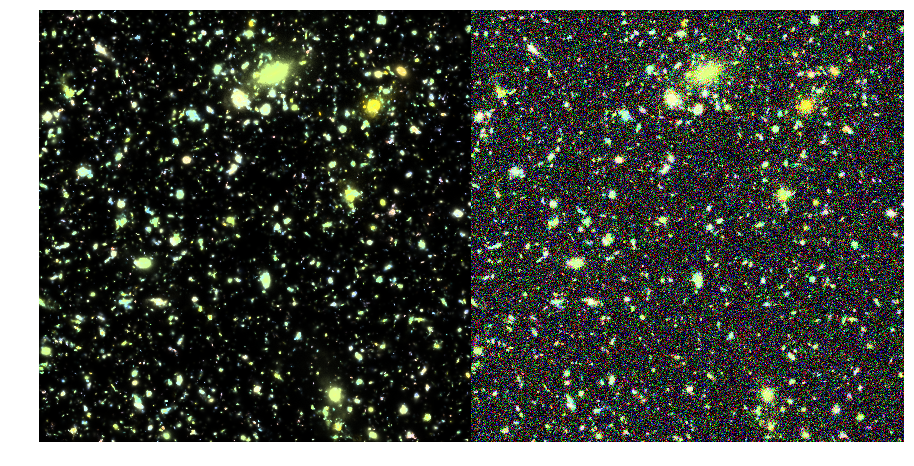

In [16]:
# Convolve with a Gaussian PSF and add Gaussian noise
image1 = make_interactive(ba,ga,ra,2,.5)
image1noise = make_interactive(ba,ga,ra,2,.5,fwhm_pixels=fwhm_pix,sigma_tuple=[.2,.2,.2])
compare_images(image1,image1noise)

### Zoom in ...

In [21]:
xmin = 3800; xmax = xmin+500; ymin = 3900; ymax = ymin+500
slc = (slice(xmin,xmax), slice(ymin,ymax))
region = image1noise[slc]
#print(500*.032/60) # length of cutout in arcmin = 0.27

In [22]:
bcut = ba[slc]; gcut = ga[slc]; rcut = ra[slc]
alpha = 1; Q = .7

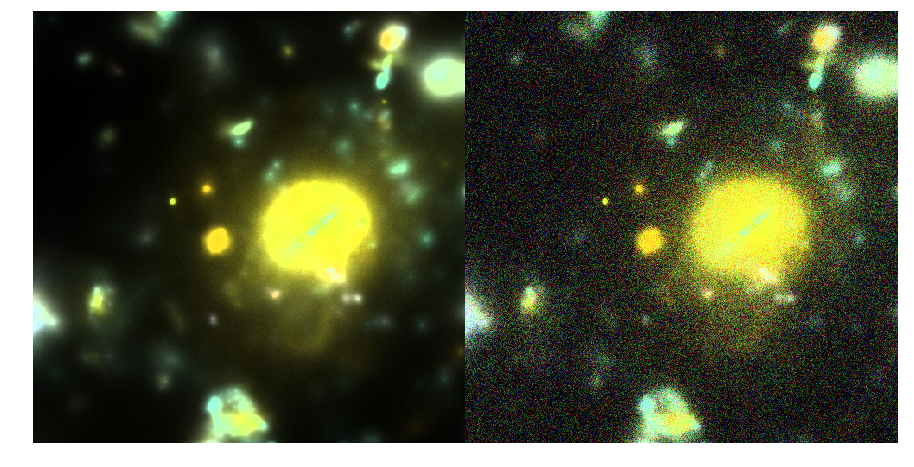

In [23]:
region = make_interactive(bcut,gcut,rcut,alpha,Q)
region_noise = make_interactive(bcut,gcut,rcut,alpha,Q,fwhm_pixels=fwhm_pix,sigma_tuple=[.2,.2,.2])
compare_images(region,region_noise)

# 2. Extract sources
## We'll analyze an individual filter image instead of the RGB

In [63]:
imfile = '{}hlsp_misty_illustris_wfirst-wfidrm15_{}_{}_v1_lightcone.fits'.format(basedir,fieldstr,jfiltstr)
hdulist = fits.open(imfile)
j_hdu = hdulist[0]
j_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5327                                                  
NAXIS2  =                 5327                                                  
EXTEND  =                    T                                                  
FILTER  = 'J129    '           / filter                                         
PIXSIZE =                0.032 / arcsec                                         
UNIT    = 'nanoJanskies'       / per pixel                                      
ABZP    =    31.40006562228223 / AB mag zeropoint                               
EXTNAME = 'IMAGE_NOPSF'                                                         
DOI     = 'https://doi.org/10.1093/mnras/stx487'                                
AUTHOR  = 'Gregory F. Snyder

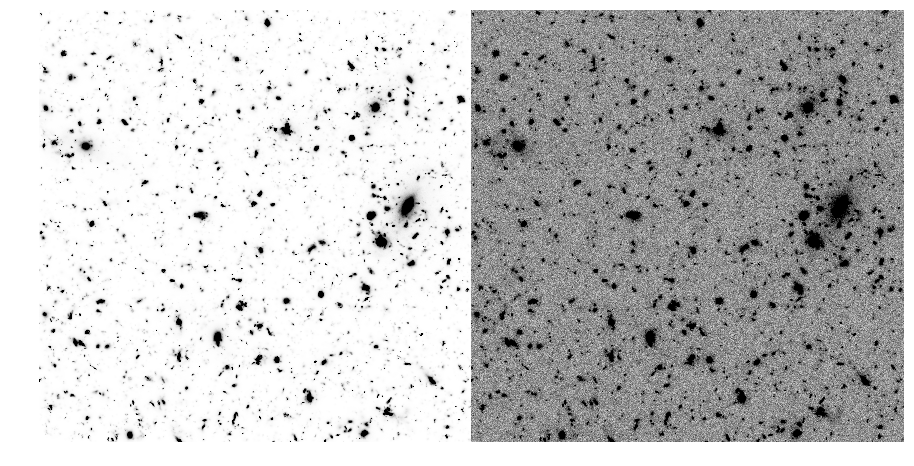

In [24]:
# Convolve with Gaussian PSF (for now) and add noise
clean = little_f(j129,np.min(j129),np.max(j129),Q,alpha)
fwhm_rad = 1.22*1.29*1.e-6/2.4 # FOR J ONLY
fwhm_arcsec = fwhm_rad*(180/np.pi)*3600
fwhm_pix = fwhm_arcsec/.11 # .11"/pixel from 2017 reference ppt slides
s = np.zeros_like(j129)
sigma = fwhm_pix/(2.0*np.sqrt(2.0*np.log(2.0)))
res = sp.ndimage.filters.gaussian_filter(j129,sigma,output=s)
data = s
# Gaussian noise for now...
sigma = .1
data = data + sigma*np.random.standard_normal(data.shape)
# Plot
noise = little_f(data,np.min(data),np.max(data),Q,alpha)
compare_images(clean,noise,cmap='Greys')

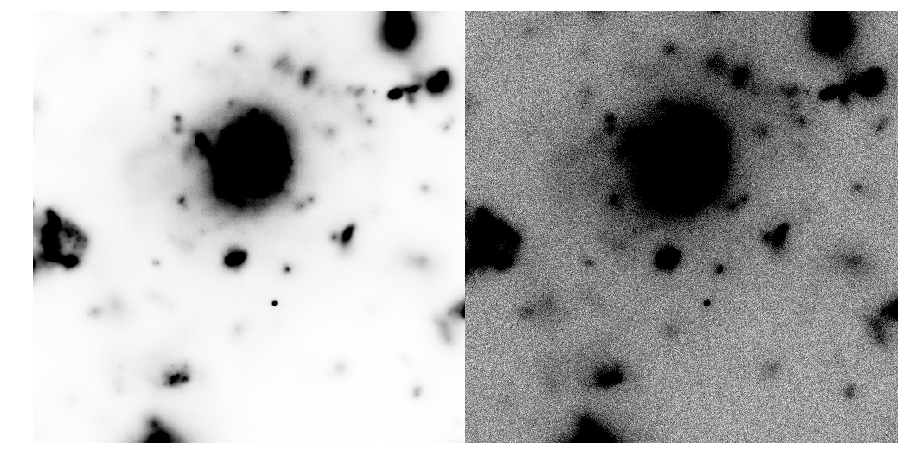

In [26]:
compare_images(clean[slc],noise[slc],cmap='Greys')
# our cut-out has become rotated by 90 degrees somehow...

## We'll use photutils to run image segmentation. Software can be pre-installed on a WFIRST docker image so you don't have to do it yourself, and so you can run batch compute jobs.

In [27]:
# Extract sources using PhotUtils
mean, median, std = astropy.stats.sigma_clipped_stats(noise, sigma=3.0, iters=5)
thresh = mean+2*std
npixels = 5
# build kernel for pre-filtering
typical_kpc_per_arcsec = 8.0 #image_hdu.header['PSCALE']
pix_arcsec = .11 # from Gaussian PSF convolution above
kernel_kpc_fwhm = 2.0
kernel_arcsec_fwhm = kernel_kpc_fwhm/typical_kpc_per_arcsec
kernel_pixel_fwhm = kernel_arcsec_fwhm/pix_arcsec

sigma = kernel_pixel_fwhm * astropy.stats.gaussian_fwhm_to_sigma
nsize = int(5*kernel_pixel_fwhm)
kernel = astropy.convolution.Gaussian2DKernel(sigma, x_size=nsize, y_size=nsize)

segmap_obj = phot.detect_sources(data, thresh, npixels=npixels, filter_kernel=kernel)
#segmap_obj = phot.detect_sources(data, thresh, npixels=npixels)
segmap = segmap_obj.data

Text(0.5,1,'Segmentation Image')

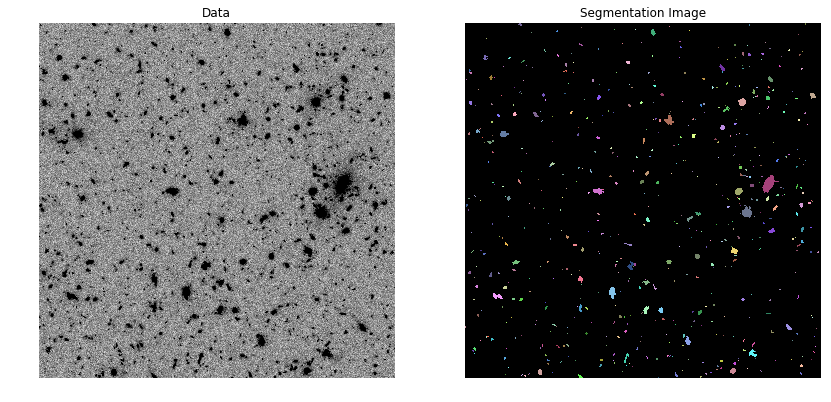

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8),frameon=False)
ax1.imshow(noise, origin='lower', cmap='Greys')
ax1.set_axis_off()
ax1.set_title('Data')
ax2.imshow(segmap_obj, origin='lower', cmap=segmap_obj.cmap(random_state=12345))
ax2.set_axis_off()
ax2.set_title('Segmentation Image');

### Let's look again at our galaxy from before

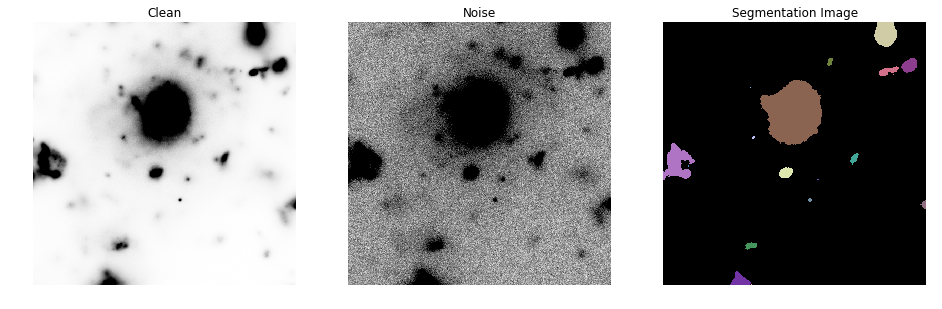

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6),frameon=False)
ax1.imshow(clean[slc],origin='lower',cmap='Greys')
ax1.set_axis_off()
ax1.set_title('Clean')
ax2.imshow(noise[slc], origin='lower', cmap='Greys')
ax2.set_axis_off()
ax2.set_title('Noise')
ax3.imshow(segmap[slc], origin='lower', cmap=segmap_obj.cmap(random_state=12345))
ax3.set_axis_off()
ax3.set_title('Segmentation Image');

In [43]:
# Try deblending (Just the cut-out)
deblend = phot.deblend_sources(data[slc],segmap_obj.data[slc],npixels=npixels,filter_kernel=kernel,contrast=.001)

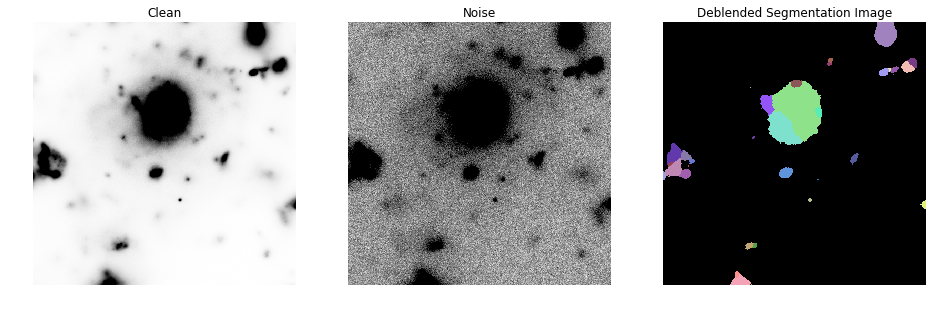

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6),frameon=False)
ax1.imshow(clean[slc],origin='lower',cmap='Greys')
ax1.set_axis_off()
ax1.set_title('Clean')
ax2.imshow(noise[slc], origin='lower', cmap='Greys')
ax2.set_axis_off()
ax2.set_title('Noise')
ax3.imshow(deblend.data, origin='lower', cmap=deblend.cmap(random_state=12345))
ax3.set_axis_off()
ax3.set_title('Deblended Segmentation Image');

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8),frameon=False)
ax1.imshow(noise, origin='lower', cmap='Greys')
ax1.set_axis_off()
ax1.set_title('Data')
ax2.imshow(deblend, origin='lower', cmap=deblend.cmap(random_state=12345))
ax2.set_axis_off()
ax2.set_title('Deblended Segmentation Image');

### Now calculate the source properties

In [49]:
props = phot.source_properties(data, segmap)

In [50]:
tbl = props.to_table(exclude_columns=('sky_centroid','sky_centroid_icrs','background_sum','background_mean','background_at_centroid'))

In [51]:
tbl

<QTable length=961>
  id      xcentroid      ...          cxy                  cyy         
             pix         ...        1 / pix2             1 / pix2      
int64      float64       ...        float64              float64       
----- ------------------ ... --------------------- --------------------
    1 1733.5107121976241 ...  0.020314821813917566 0.017506348576354275
    2  3527.509335221281 ...  -0.03735168762485555 0.023361589576364764
    3 3099.8250916126362 ...    0.1072768552735807  0.14215694252127364
    4  2894.116525422351 ...  -0.38922900381353687   0.2933385195046435
    5  2883.164069012497 ...    -1.224052341632155    6.926119009208184
    6  906.1088265099071 ...   0.02117941601722991  0.01202701886330301
    7 3164.8741476211726 ...  0.012915915426787668 0.006994558877759802
    8  853.6713349846286 ... -0.049414910499552045 0.023813927070087042
    9 2030.6346519080048 ...   0.07072138898990002  0.37634923016622074
  ...                ... ...                   ...                  ...
  952 1609.8687299808248 ...   0.29108883990679507  0.16444098927639508
  953 29.385101485901608 ...  -0.09016178949156642   0.1906284005758262
  954  824.9698246708496 ...  0.007871417235033255 0.018047644147871317
  955  4260.199864916746 ... -0.011181838073907003  0.04732789933267661
  956   21.8303186703712 ...   0.08239881924156434  0.23077959169583528
  957  5095.619983620319 ... -0.047621708939432655   0.0627159953112485
  958  716.4999596533967 ...  0.015561715812763733   1.1238794887505328
  959  2934.447503070675 ...  0.007015556989874186   0.0395137120901433
  960 1411.5029400930575 ...  -0.13420326276862157  0.13161992422005125
  961  2516.603765770571 ...   0.08086966090482636  0.13442971714725963

In [52]:
tbl.colnames

['id',
 'xcentroid',
 'ycentroid',
 'source_sum',
 'source_sum_err',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'min_value',
 'max_value',
 'minval_xpos',
 'minval_ypos',
 'maxval_xpos',
 'maxval_ypos',
 'area',
 'equivalent_radius',
 'perimeter',
 'semimajor_axis_sigma',
 'semiminor_axis_sigma',
 'eccentricity',
 'orientation',
 'ellipticity',
 'elongation',
 'covar_sigx2',
 'covar_sigxy',
 'covar_sigy2',
 'cxx',
 'cxy',
 'cyy']

# 3. Load your results into a database
### Convert the table to a pandas data-frame, which can be loaded to a table in MyDB

In [53]:
import pandas as pd
import SciServer.CasJobs as cj

In [54]:
df = tbl.write('j129_sig1_csv',format='csv')
df = pd.read_csv('j129_sig1_csv')

In [55]:
df

id    xcentroid    ycentroid    source_sum source_sum_err    xmin  \
0      1  1733.510712    13.567322  10781.430478           None  1690.0   
1      2  3527.509335    13.750865   1602.591634           None  3515.0   
2      3  3099.825092     5.885211    103.374696           None  3096.0   
3      4  2894.116525     6.906555     64.927242           None  2887.0   
4      5  2883.164069     3.198398      4.792231           None  2881.0   
5      6   906.108827    28.779266   1994.375225           None   885.0   
6      7  3164.874148    39.635845   3008.544933           None  3144.0   
7      8   853.671335    38.642534    761.575083           None   844.0   
8      9  2030.634652    29.834447     29.933002           None  2028.0   
9     10  3242.481461    32.248602    148.357415           None  3237.0   
10    11   955.605030    47.007325    471.393873           None   941.0   
11    12  1120.567877    85.998531  17213.303166           None  1086.0   
12    13  3955.389526    45.951668    159.699967           None  3950.0   
13    14   611.346939    58.630018    272.534734           None   606.0   
14    15  5027.103830    62.224568   1267.074942           None  5007.0   
15    16  3608.806803    63.426422   1111.812939           None  3592.0   
16    17  1693.739539    56.242111      6.562636           None  1693.0   
17    18  4011.275139   106.961146  18414.118747           None  3965.0   
18    19   963.213358    73.160260    125.567211           None   959.0   
19    20  1311.652522    82.269809    609.962391           None  1306.0   
20    21  3683.389009    85.268799    742.551263           None  3668.0   
21    22  2334.856890    87.929587     28.796800           None  2332.0   
22    23  2352.753263    97.506357    584.834791           None  2338.0   
23    24   955.609916    92.615789     85.101196           None   948.0   
24    25  4436.018765    92.708004     83.959058           None  4430.0   
25    26   492.799631   100.036994     20.169536           None   490.0   
26    27  2511.635059   104.274385     38.362915           None  2509.0   
27    28  4427.181614   112.712173     77.634519           None  4421.0   
28    29  3258.418115   114.666539     93.239857           None  3254.0   
29    30  3773.296147   131.796560    387.127581           None  3762.0   
..   ...          ...          ...           ...            ...     ...   
931  932   322.897814  5073.653157    144.450636           None   318.0   
932  933  4277.864123  5118.441463     30.955954           None  4275.0   
933  934  2814.327958  5167.456774  14819.703010           None  2778.0   
934  935  4991.456702  5139.300513     75.916475           None  4986.0   
935  936  4620.761582  5143.509389    100.914596           None  4614.0   
936  937  3701.664143  5161.485634    268.680795           None  3697.0   
937  938   998.410744  5168.680154    813.383756           None   985.0   
938  939   115.824299  5168.534179    117.563596           None   109.0   
939  940  1383.341974  5186.960424   1172.896072           None  1365.0   
940  941  1020.260998  5174.986440     27.702570           None  1017.0   
941  942   388.741805  5188.667651     28.325718           None   386.0   
942  943  3362.330540  5202.300447    321.602775           None  3355.0   
943  944  2555.385871  5210.942088    254.350050           None  2545.0   
944  945  2239.972317  5211.036542    304.267904           None  2235.0   
945  946  1716.429678  5223.251633     41.852435           None  1712.0   
946  947  2862.526646  5234.540924     82.194164           None  2857.0   
947  948  1735.801955  5246.880048    568.578352           None  1716.0   
948  949  2552.980141  5238.686099     14.937301           None  2551.0   
949  950  1583.051213  5256.468860     28.923252           None  1580.0   
950  951  3060.395393  5262.849401    154.038270           None  3055.0   
951  952  1609.868730  5267.232292     28.342380           None  1607.0   
952  953    29.385101  5270.170

In [56]:
cj.uploadPandasDataFrameToTable(df,tableName='j129sig1');

### Specify the SQL query that will choose what goes into the table. For now, get everything.

In [60]:
sql = """
select * from j129sig1
"""

In [61]:
df = cj.executeQuery(sql,context='MyDB')

### Now go to CasJobs and see the table in your MyDB! Publish it to your group to share with collaborators.
# 4. Compare your extracted objects to the halo catalog
## The fits files contain the image plus the information from the catalog that created it

In [13]:
hdulist.info()

Filename: /home/idies/workspace/wfirst/Illustris/mag30-fielda-11-10/hlsp_misty_illustris_wfirst-wfidrm15_mag30-fielda-11-10_j129_v1_lightcone.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  IMAGE_NOPSF    1 PrimaryHDU      24   (5327, 5327)   float64   
  1  SimulationAssumptions    1 BinTableHDU     15   1R x 2C   [47A, 48A]   
  2  MockDataAssumptions    1 ImageHDU        12   ()      
  3  Catalog       1 BinTableHDU    131   6524R x 61C   [K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 11A, K, K, D, D, D, K, K, D, D, D, D, K, K, D, D, K, 117A, L, D, D, D]   
  4  CatalogDocumentation    1 BinTableHDU    131   1R x 61C   [61A, 57A, 61A, 15A, 14A, 35A, 50A, 50A, 50A, 66A, 76A, 48A, 48A, 48A, 45A, 32A, 51A, 2A, 37A, 78A, 39A, 39A, 101A, 84A, 39A, 74A, 55A, 46A, 50A, 144A, 144A, 47A, 137A, 137A, 12A, 70A, 155A, 158A, 39A, 36A, 51A, 42A, 57A, 55A, 41A, 35A, 44A, 25A, 63A, 28A, 129A, 50A, 84A, 3

In [64]:
truecat = hdulist[3]
truecat.columns

ColDefs(
    name = 'snapshot'; format = 'K'
    name = 'SubfindID'; format = 'K'
    name = 'ra_deg'; format = 'D'
    name = 'dec_deg'; format = 'D'
    name = 'ra_kpc'; format = 'D'
    name = 'dec_kpc'; format = 'D'
    name = 'ra_kpc_inferred'; format = 'D'
    name = 'dec_kpc_inferred'; format = 'D'
    name = 'true_z'; format = 'D'
    name = 'inferred_z'; format = 'D'
    name = 'peculiar_z'; format = 'D'
    name = 'true_kpc_per_arcsec'; format = 'D'
    name = 'X_cmpc'; format = 'D'
    name = 'Y_cmpc'; format = 'D'
    name = 'Z_cmpc'; format = 'D'
    name = 'ADD_cmpc'; format = 'D'
    name = 'ADD_cmpc_inferred'; format = 'D'
    name = 'snapshot_z'; format = 'D'
    name = 'geometric_z'; format = 'D'
    name = 'cylinder_number'; format = 'K'
    name = 'mstar_msun_rad'; format = 'D'
    name = 'mgas_msun_rad'; format = 'D'
    name = 'subhalo_mass_msun'; format = 'D'
    name = 'bhmass_msun_rad'; format = 'D'
    name = 'mbary_msun_rad'; format = 'D'
    name = 'sfr_msun

In [65]:
cat = truecat.data

In [89]:
length = 1000; l2 = length/2
xmin = 3500; xmax = xmin+length; ymin = 3500; ymax = ymin+length
slc = (slice(xmin,xmax), slice(ymin,ymax))
pixtodeg = .032/3600; Npix = segmap.shape[0]
extent = (xmin-Npix/2)*pixtodeg,(xmax-Npix/2)*pixtodeg,(ymin-Npix/2)*pixtodeg,(ymax-Npix/2)*pixtodeg
subset = np.where((cat['ra_deg']>extent[0]) & (cat['ra_deg']<extent[1])\
                  & (cat['dec_deg']>extent[2]) & (cat['dec_deg']<extent[3]))[0]

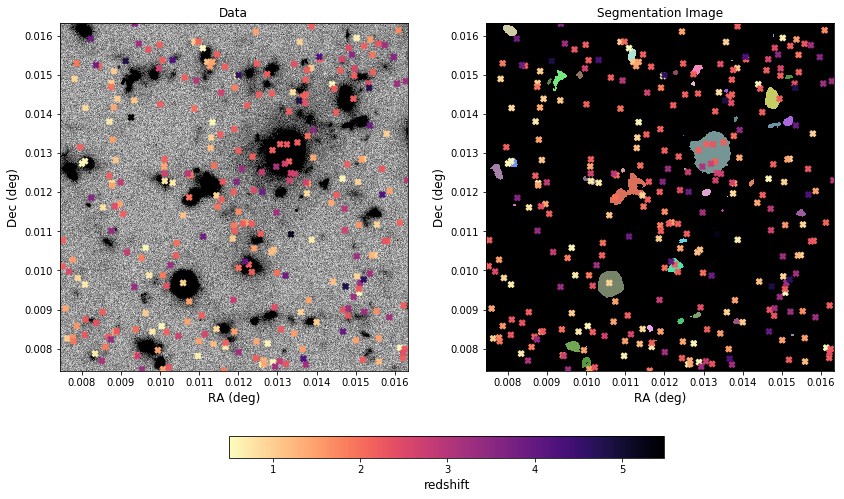

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
ax1.imshow(noise[slc], origin='lower', cmap='Greys',extent=extent)
ax1.set_title('Data')
im1 = ax1.scatter(cat['ra_deg'][subset],cat['dec_deg'][subset],marker='X',c=cat['inferred_z'][subset],cmap='magma_r')
ax1.set_xlim((extent[0],extent[1]))
ax1.set_ylim((extent[2],extent[3]))
ax1.set_xlabel('RA (deg)',size='large')
ax1.set_ylabel('Dec (deg)',size='large')
ax2.imshow(segmap[slc],origin='lower',cmap=segmap_obj.cmap(random_state=12345),extent=extent)
ax2.set_title('Segmentation Image');
im2 = ax2.scatter(cat['ra_deg'][subset],cat['dec_deg'][subset],marker='X',c=cat['inferred_z'][subset],cmap='magma_r')
ax2.set_xlim((extent[0],extent[1]))
ax2.set_ylim((extent[2],extent[3]))
ax2.set_xlabel('RA (deg)',size='large')
ax2.set_ylabel('Dec (deg)',size='large')
cbar = fig.colorbar(im1,ax=(ax1,ax2),orientation='horizontal',fraction=.05)
cbar.set_label('redshift',size='large');